In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb
conn = duckdb.connect()

In [2]:
import os 
os.chdir("../") # To read the data from the root folder

# So we get two tables, one with the fractioned transactions per subsidiary, and the original

- So let's check how they are

In [3]:
original_path = 'data/sample_data_0006_part_00.parquet'

fractioned_transactions_path = 'data/interim/fractioned_transactions.parquet'



original_query = f"""
    SELECT *
    FROM read_parquet('{original_path}')
    LIMIT 10
"""
original_df_head = conn.execute(original_query).df()
original_df_head

,merchant_id,_id,subsidiary,transaction_date,account_number,user_id,transaction_amount,transaction_type
0,075d178871d8d48502bf1f54887e52fe,aa8dacff663072244d0a8ab6bbe36b93,824b2af470cbe6a65b15650e03b740fc,2021-09-12 18:32:03,648e257c9d74909a1f61c54b93a9e1b3,ba42d192a145583ba8e7bf04875f837f,178.333650,CREDITO
1,075d178871d8d48502bf1f54887e52fe,a53bb81bd0bba2ae2535bda7ea5a550c,2d8d34be7509a6b1262336d036fdb324,2021-09-12 18:31:58,c0b62f9046c83ea5543ea46a497a4d6e,5cfff960ea6d732c1ba3e63d24f3be52,35.666730,CREDITO
2,075d178871d8d48502bf1f54887e52fe,79f893ea65c06fe2933f3847c88c272f,5eeb18254850b21af0a6bb2697913cd3,2021-09-12 18:31:56,872d10143fc0ac7d5de467806f6bef81,c97e63a92c82c7217b333635d75928ed,142.666920,CREDITO
3,075d178871d8d48502bf1f54887e52fe,ce577223699dbdc119df2ab8a35457fe,5221a599856c0a0588ed9ffd150edd3b,2021-09-12 18:31:10,2e35cfe7860a480a93e1c83e99843579,fc09bdd00f283222d65eaff4d00a6594,8.322237,CREDITO
4,075d178871d8d48502bf1f54887e52fe,0ce7ab2950e7a788a608f881aec0f8f0,971e55ef12d80ec070ea4f6750c8b892,2021-09-12 18:31:07,995bc89e4c4e00334f1f90c4a55f4729,213527e8ba94fcaf2f9378969f9f6abc,32.100057,CREDITO
5,075d178871d8d48502bf1f54887e52fe,01220d4c4ed48cfd6f7ca5f278f9a6f6,76aca4525838053ca0d5ba8e37f1ffe8,2021-09-12 18:31:06,a32395153b2dc1383304bd2c33990a78,d1022ab075c2a2cf681398670d2bf8a1,59.444550,CREDITO
6,075d178871d8d48502bf1f54887e52fe,f02cabf07366d25120c9b2e7019a4205,6b102b2df10e986bd97b1b5713be0843,2021-09-12 18:30:55,2dd7afef1abfbfbbb68b6a31df70fc91,d6b9f3858016e0581e006ad574e23c6c,11.888910,CREDITO
7,075d178871d8d48502bf1f54887e52fe,fb12816c831921ff105fea2197ab26b1,3ae3115ca051e75384016f7dbe2e1c44,2021-09-12 18:30:44,b203ec1d2e5355a406451c5a664fd1fe,fed67132093416ba01a45b31d907d437,29.722275,CREDITO
8,075d178871d8d48502bf1f54887e52fe,faf1f94ffdcd14b92523439672079498,408c74e90c79b159c91267b8fdf11053,2021-09-12 18:30:15,8bd7618563c9e4e9c1cee885a8816188,09e64f7c1df4eb1acd93733bc7c699a7,23.777820,CREDITO
9,075d178871d8d48502bf1f54887e52fe,76d975dce75647824a3ff3d1c8e4fa4c,30e5a216a97f0b59114d79b0b69061a2,2021-09-12 18:29:45,c4703b5e8501767be83fe2b258ffc7ee,320b4b756f3584ee36738cf8cd60a581,41.611185,CREDITO


In [4]:
fractioned_transactions_query = f"""
    SELECT *
    FROM read_parquet('{fractioned_transactions_path}')
    LIMIT 10
"""
fractioned_transactions_df_head = conn.execute(fractioned_transactions_query).df()
fractioned_transactions_df_head

,_id,fractioned_label,is_outlier
0,0ce7ab2950e7a788a608f881aec0f8f0,626357,0
1,d32cb4ab941c3ebecb19cf7d24b7685a,373031,0
2,84a07b1ddbb4ad36af95de852538f07b,373031,0
3,babf9588c0ae9b33ad452033b10d5bea,96141,0
4,6b61df935e65c3e983b17afa69590572,118584,0
5,41360e65057396d7fbae670cf24c7532,96141,0
6,3ec93bb3e86ca3335b164297262a382b,648861,0
7,8ffce3441ea2e1def8cf3c975bef39d9,373031,0
8,a5ef6a1623517c3ce2c905a5f629f0d9,595860,0
9,01adaa303b60d5e7d802969a93757328,595860,0


# So these tables are constructed following a relational approach.
- The key to relate both tables is the `_id` column.

**Analysis plan:**
- So now we can create groupings for user, account, and merchant (or subsidiary) level analysis.
- Let's begin with the group by `merchant_id` analysis.

In [5]:
merch_grouped_query = f"""
WITH 
fractioned_transactions AS (
    SELECT *
    FROM read_parquet('{fractioned_transactions_path}')
)
    SELECT
        merchant_id,
        subsidiary,        
        MAX(transaction_amount) AS max_transaction_amount,
        PERCENTILE_CONT(0.9) WITHIN GROUP (ORDER BY transaction_amount) AS percentile_90,
        AVG(transaction_amount) AS avg_amount,
        STDDEV(transaction_amount) AS stddev_amount,
        SUM(transaction_amount) AS total_transactions_amount,
        COUNT(DISTINCT ft.fractioned_label) AS fractioned_transaction_counts
    FROM read_parquet('{original_path}') txn
    LEFT JOIN 
        fractioned_transactions ft
    ON 
        txn._id = ft._id        
    GROUP BY merchant_id, subsidiary

"""
merch_grouped_df = conn.execute(merch_grouped_query).df()
merch_grouped_df

,merchant_id,subsidiary,max_transaction_amount,percentile_90,avg_amount,stddev_amount,total_transactions_amount,fractioned_transaction_counts
0,075d178871d8d48502bf1f54887e52fe,38cd69155c5913b2d354a946591468ed,594.445501,356.667301,161.755771,127.327855,6.858445e+04,19
1,075d178871d8d48502bf1f54887e52fe,b38562311df6180f02365c924ea98e80,594.445501,594.445501,191.166738,195.929065,5.390902e+05,81
2,075d178871d8d48502bf1f54887e52fe,fee20d2f0753125f11b4376da5dbad4c,594.445501,594.445501,224.079013,195.897524,4.862066e+06,1083
3,075d178871d8d48502bf1f54887e52fe,9c1af92b7411fd1b585ec0f834c918c1,594.445501,594.445501,199.208433,198.453615,3.862652e+05,67
4,075d178871d8d48502bf1f54887e52fe,0a8fec90aaf58ea5374befafb89dddc3,475.556401,273.444931,112.624206,104.855515,1.312072e+05,17
...,...,...,...,...,...,...,...,...
16047,838a8fa992a4aa2fb5a0cf8b15b63755,0496e8a3c4c45eb1173d5098f692118d,71.333460,71.333460,71.333460,NaN,7.133346e+01,0
16048,838a8fa992a4aa2fb5a0cf8b15b63755,6b7eb387b2e57ca345a7737c4be6dffd,35.666730,35.666730,35.666730,NaN,3.566673e+01,0
16049,838a8fa992a4aa2fb5a0cf8b15b63755,9a5c48d4a8624f5de9b6f55d7b5c344f,594.445501,582.556591,538.963921,53.610065,1.616892e+03,1
16050,838a8fa992a4aa2fb5a0cf8b15b63755,0bbd92d514f062365d2e78c860e699cc,83.222370,79.180141,63.011223,28.582878,1.260224e+02,0


In [6]:
query = f"""
WITH 
fractioned_transactions AS (
    SELECT *
    FROM read_parquet('{fractioned_transactions_path}')
),
full_table AS (
    SELECT 
        *
    FROM read_parquet('{original_path}') txn
    LEFT JOIN 
        fractioned_transactions ft
    ON 
        txn._id = ft._id 
), 
first_subsidiary_agg AS (
    SELECT
        merchant_id,
        subsidiary,        
        MAX(transaction_amount) AS max_transaction_amount,
        PERCENTILE_CONT(0.9) WITHIN GROUP (ORDER BY transaction_amount) AS percentile_90,
        AVG(transaction_amount) AS avg_amount,
        STDDEV(transaction_amount) AS stddev_amount,
        SUM(transaction_amount) AS total_transactions_amount,
        COUNT(DISTINCT fractioned_label) AS fractioned_transaction_counts
    FROM 
        full_table    
    GROUP BY merchant_id, subsidiary
), 
second_subsidiary_agg AS (
    SELECT
        merchant_id,
        subsidiary,        
        fractioned_label,
        MAX(transaction_amount) AS max_txn_in_fraction
    FROM 
        full_table        
    WHERE 
        fractioned_label IS NOT NULL
    GROUP BY merchant_id, subsidiary, fractioned_label
),
final_aggregation AS (
    SELECT
        fsa.merchant_id,
        fsa.subsidiary,
        SUM(CASE WHEN fsa.max_transaction_amount = ssa.max_txn_in_fraction THEN 1 ELSE 0 END) AS matching_fractioned_max_amts
    FROM 
        first_subsidiary_agg fsa
    LEFT JOIN
        second_subsidiary_agg ssa
    ON
        fsa.merchant_id = ssa.merchant_id AND
        fsa.subsidiary = ssa.subsidiary
    GROUP BY
        fsa.merchant_id,
        fsa.subsidiary
)
SELECT 
    fsa.*,
    fa.matching_fractioned_max_amts,
    fa.matching_fractioned_max_amts / fsa.fractioned_transaction_counts AS fractioned_max_amt_match_ratio
FROM 
    first_subsidiary_agg fsa
INNER JOIN
    final_aggregation fa
ON
    fsa.merchant_id = fa.merchant_id AND
    fsa.subsidiary = fa.subsidiary
"""

merch_grouped_df = conn.execute(query).df()
merch_grouped_df

,merchant_id,subsidiary,max_transaction_amount,percentile_90,avg_amount,stddev_amount,total_transactions_amount,fractioned_transaction_counts,matching_fractioned_max_amts,fractioned_max_amt_match_ratio
0,075d178871d8d48502bf1f54887e52fe,70ca3fd74684e0fd1d0389f642c1b9a7,594.445501,356.667301,138.516188,149.417084,456964.903919,56,27.0,0.482143
1,075d178871d8d48502bf1f54887e52fe,b5d946f51fcc7dd6608088cd8c795356,594.445501,475.556401,162.850342,173.464932,323420.779426,60,44.0,0.733333
2,075d178871d8d48502bf1f54887e52fe,eea9943b1b7e1f43e1ef60716bba1e9f,594.445501,456.534145,145.736876,163.734775,39203.219515,13,2.0,0.153846
3,075d178871d8d48502bf1f54887e52fe,d111586dfb557759cb6f76e8348be047,8.322237,8.322237,7.331495,0.686407,87.977934,3,1.0,0.333333
4,075d178871d8d48502bf1f54887e52fe,42e2cf94108ebdcfc17f9781d0634dbb,8.322237,8.322237,7.356263,0.991733,117.700209,6,6.0,1.000000
...,...,...,...,...,...,...,...,...,...,...
16047,838a8fa992a4aa2fb5a0cf8b15b63755,ebf9e3ca0287b3a62ab2a24822936e0e,23.777820,23.777820,23.777820,NaN,23.777820,0,0.0,NaN
16048,838a8fa992a4aa2fb5a0cf8b15b63755,53dcb7f5bc9eef2d772e01dbac360bc3,214.000380,162.283622,77.872361,74.260496,467.234164,0,0.0,NaN
16049,838a8fa992a4aa2fb5a0cf8b15b63755,d6aaf5f9b814d909b7c5e2ef146e305c,23.777820,23.777820,23.777820,NaN,23.777820,0,0.0,NaN
16050,838a8fa992a4aa2fb5a0cf8b15b63755,d2e5af01632bcb5d0f6f87f58c71361e,594.445501,594.445501,594.445501,NaN,594.445501,0,0.0,NaN


In [7]:
merch_grouped_df['fractioned_transaction_counts'].sum()

np.int64(678398)

# So lets check if the fractioned transactions amounts are realated with the commerce or subsidiary max transaction received.

- This could be an indicator that the fractioned transactions are due to limits or rates in that subsidiary.

In [8]:
merch_grouped_df.sort_values(by='fractioned_max_amt_match_ratio', ascending=False)


,merchant_id,subsidiary,max_transaction_amount,percentile_90,avg_amount,stddev_amount,total_transactions_amount,fractioned_transaction_counts,matching_fractioned_max_amts,fractioned_max_amt_match_ratio
12648,838a8fa992a4aa2fb5a0cf8b15b63755,4a3be47dc3c33162909472355b982cb3,594.445501,188.320335,92.777531,153.133692,2504.993342,1,1.0,1.0
6069,075d178871d8d48502bf1f54887e52fe,7007461f1d9681efc740547befa52fa4,5.944455,5.944455,5.944455,0.000000,172.389195,3,3.0,1.0
6066,075d178871d8d48502bf1f54887e52fe,98265a6bd1cdeb8139bcebf7f9df0626,594.445501,470.800837,175.235962,170.812187,28913.933802,3,3.0,1.0
6063,075d178871d8d48502bf1f54887e52fe,ae7b5b095d412a6351ce97b59c835f37,8.322237,8.322237,7.270526,0.845830,189.033669,5,5.0,1.0
6049,838a8fa992a4aa2fb5a0cf8b15b63755,96b47a552918f60e77c641b542c140ab,17.833365,16.644474,11.888910,8.406729,23.777820,1,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
16047,838a8fa992a4aa2fb5a0cf8b15b63755,ebf9e3ca0287b3a62ab2a24822936e0e,23.777820,23.777820,23.777820,NaN,23.777820,0,0.0,NaN
16048,838a8fa992a4aa2fb5a0cf8b15b63755,53dcb7f5bc9eef2d772e01dbac360bc3,214.000380,162.283622,77.872361,74.260496,467.234164,0,0.0,NaN
16049,838a8fa992a4aa2fb5a0cf8b15b63755,d6aaf5f9b814d909b7c5e2ef146e305c,23.777820,23.777820,23.777820,NaN,23.777820,0,0.0,NaN
16050,838a8fa992a4aa2fb5a0cf8b15b63755,d2e5af01632bcb5d0f6f87f58c71361e,594.445501,594.445501,594.445501,NaN,594.445501,0,0.0,NaN


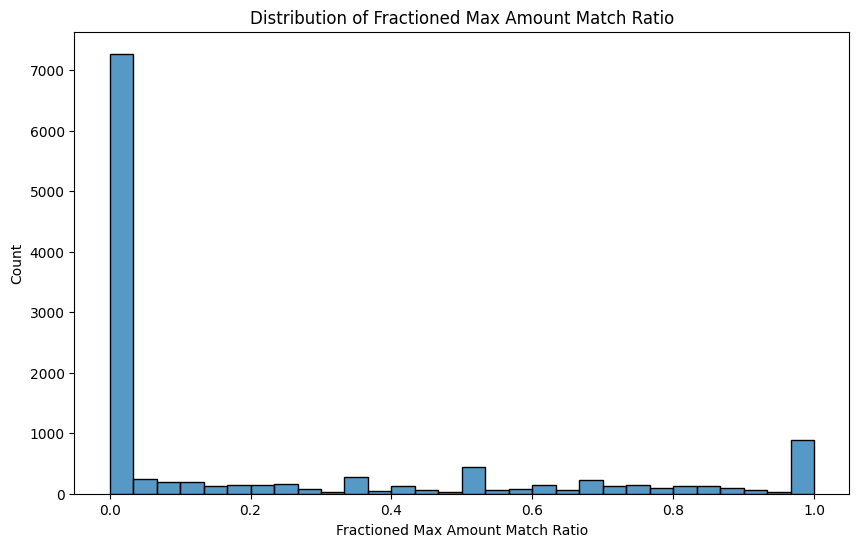

In [9]:
fig, ax = plt.subplots(figsize=(10,6))
sns.histplot(merch_grouped_df['fractioned_max_amt_match_ratio'].dropna(), bins=30, ax=ax)
ax.set_title('Distribution of Fractioned Max Amount Match Ratio')
ax.set_xlabel('Fractioned Max Amount Match Ratio')
ax.set_ylabel('Count')
plt.show()

Even though there are many subsidiaries where the rate of fractioned transactions that match the subsidiary max trasaction received, is in many cases 0.
- There are also a lot of subsidiaries where this ratio is 1, meaning that all fractioned transactions correspond to the max transaction received in that subsidiary.
- This could indicate a limit imposed by the subsidiary that causes users to fraction their transactions.

# plot the distrib for transa

- lets explore for each merch, how is the distribution of some variables
  - subsidiary count (barplot)
  - distrib max_transaction_amount (histogram) to gain insights about the maximum per subsidiary (if exist)
  - distrib percentile 90 (histogram) maybe useful to detect outliers
  - distrib avg_amount (histogram) to see if it follows a normal distrib
  - fractioned_transaction_counts (histogram) to see how many fractioned transactions per merchant exist

merchant_id: 075d1, amount_of_subsidiaries: 4178
merchant_id: 817d1, amount_of_subsidiaries: 5233
merchant_id: 838a8, amount_of_subsidiaries: 6641


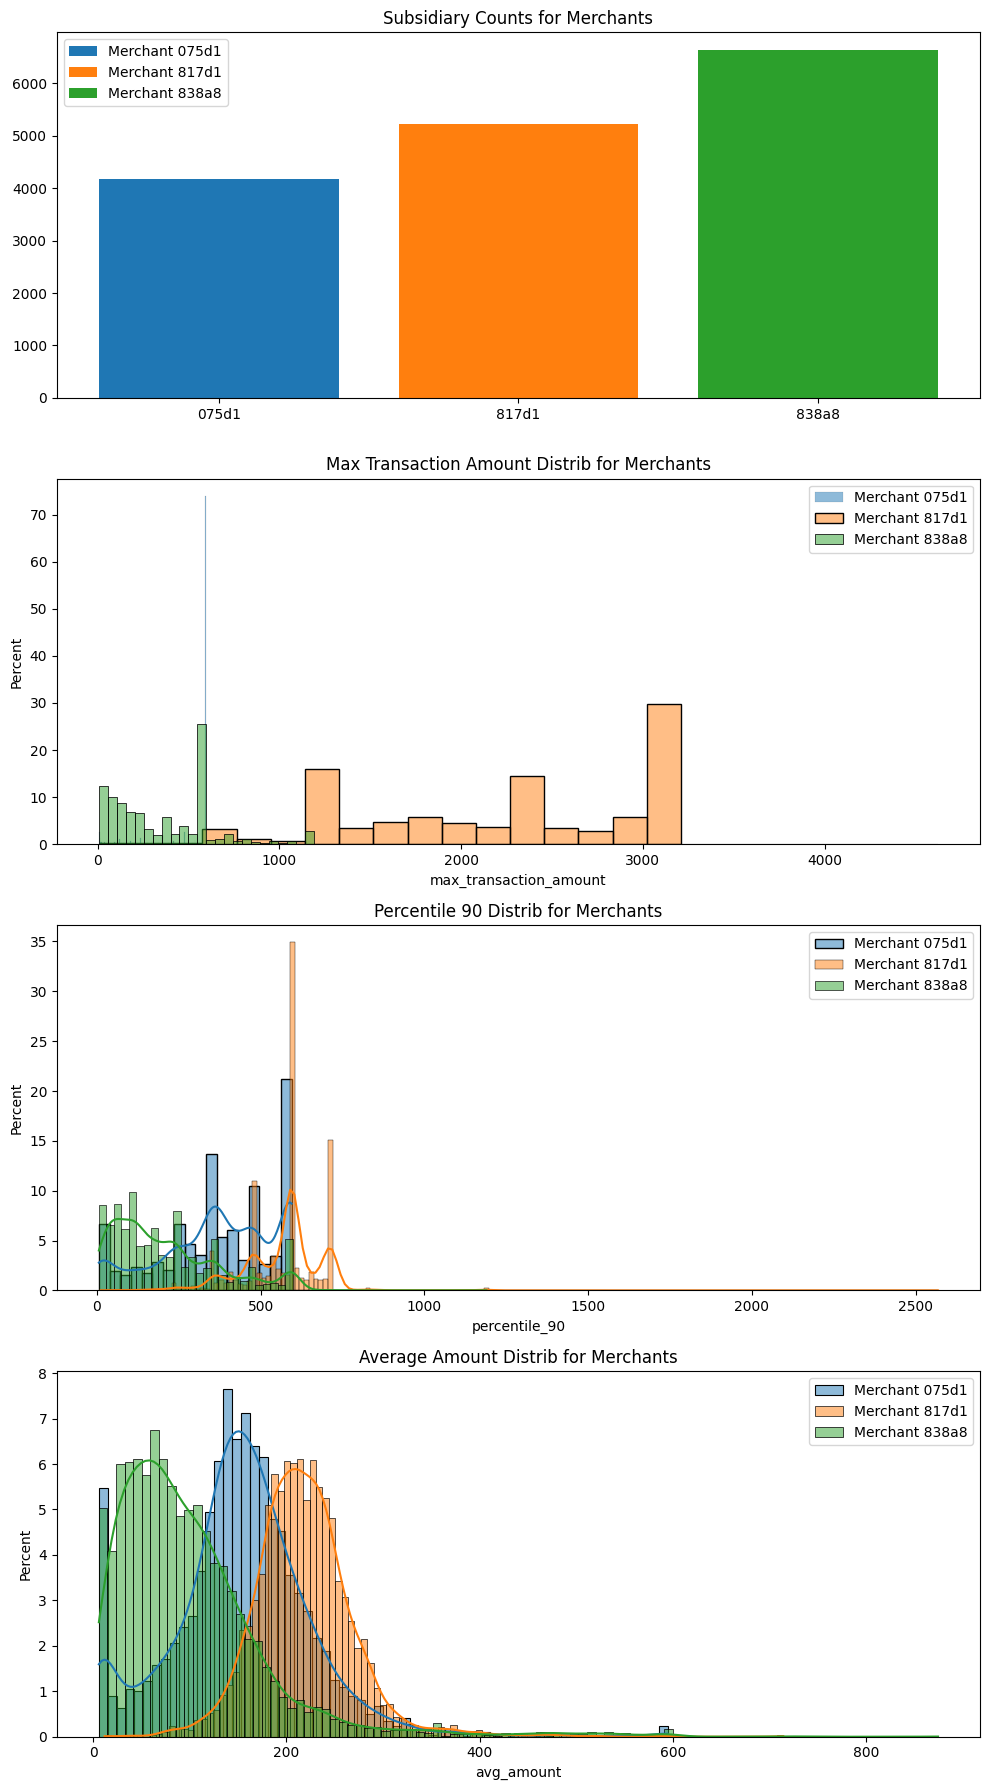

In [10]:
fig, ax = plt.subplots(4, 1, figsize=(10, 6*3))


subsidiary_counts = {}
for name, merchant_group in merch_grouped_df.groupby('merchant_id'):    
    name = name[:5]
    amount_of_subsidiaries = merchant_group['subsidiary'].nunique()
    print(f"merchant_id: {name[:5]}, amount_of_subsidiaries: {amount_of_subsidiaries}")
    ax[0].bar(name, amount_of_subsidiaries, label=f'Merchant {name}')
    ax[0].set_title(f'Subsidiary Counts for Merchants')
    sns.histplot(merchant_group['max_transaction_amount'], ax=ax[1], kde=False, stat='percent', label=f'Merchant {name}', alpha=0.5)
    ax[1].set_title(f'Max Transaction Amount Distrib for Merchants')
    sns.histplot(merchant_group['percentile_90'], ax=ax[2], kde=True, stat='percent', label=f'Merchant {name}')
    ax[2].set_title(f'Percentile 90 Distrib for Merchants')
    sns.histplot(merchant_group['avg_amount'], ax=ax[3], kde=True, stat='percent', label=f'Merchant {name}')
    ax[3].set_title(f'Average Amount Distrib for Merchants')
    # activate the legends
    for i in range(4):
        ax[i].legend()

plt.tight_layout()
plt.show()





# Ok, so far, according the obtained plots, we can remark the following insights:

- I will use the labels green: merchant 838a8, blue: 075d1, orange: 817d1 for ease of reference.

- The number of subsidiaries per merchant ranges from 4k to 6k. Being the blue merchant the one with less subsidiaries (~4k) and the green one the one with more subsidiaries (~6k).
- This is not really relevant, but could be useful in the future.
- The maximum transaction for each merchant is very different, particularly the orange merchant w.r.t the others.
- We can observe that per merchant, the most frequent maximum (regarding their subsidiaries) is not necessary the highest one. With the exception of the orange merchant.
- The 90th percentile distribution follows a similar pattern as the maximum transaction amount, which is expected. However, the distributions are not only smoother, but also the differences between merchants are less pronounced.
- As expected, the average transaction amount per merchant follows normal distributions. The mean of the green merchant is the lowest, followed by the blue merchant, and finally the orange merchant.

# Well. Now let's deep dive into the fractioned_transaction_counts variable.

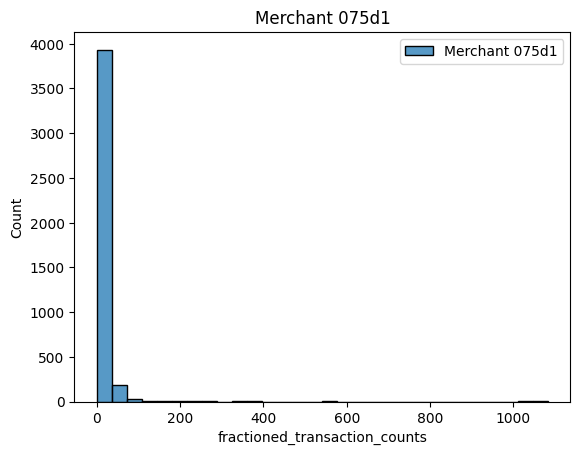

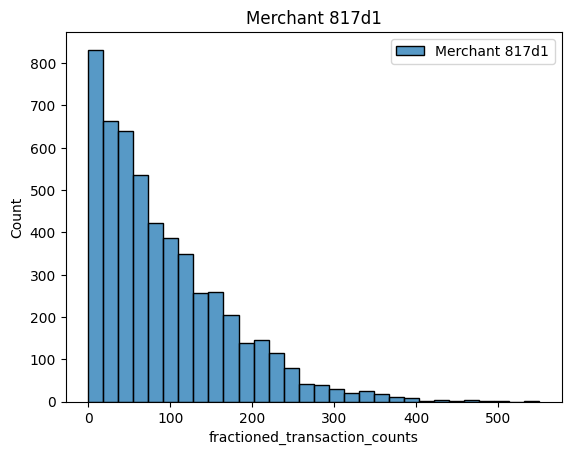

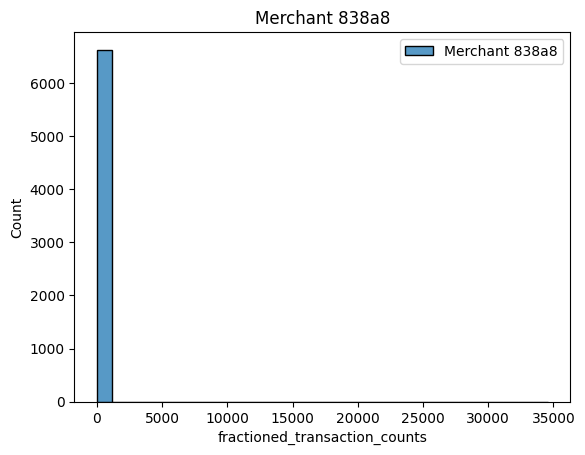

In [11]:
for i in range(len(merch_grouped_df['merchant_id'].unique())):
    merchant_id = merch_grouped_df['merchant_id'].unique()[i]
    name = merchant_id[:5]
    group_merch_df = merch_grouped_df.loc[merch_grouped_df['merchant_id'] == merchant_id]
    group_merch_df.sort_values(by='fractioned_transaction_counts', ascending=False)
    sns.histplot(group_merch_df['fractioned_transaction_counts'], bins=30, label=f'Merchant {name}')
    plt.title(f'Merchant {name}')
    plt.legend()
    plt.show()

# Well, this is really interesting. There is one merchant: 838a8, with a very wide range of fractioned transaction counts, from very low values to very high values.

- Lets check this by obtaining some dispersion metrics for each merchant.

In [12]:
merch_grouped_df.groupby('merchant_id')['fractioned_transaction_counts'].agg(['min', 'max', 'mean', 'std', 'median'])

,min,max,mean,std,median
merchant_id,,,,,
075d178871d8d48502bf1f54887e52fe,0,1083,9.900431,31.681858,3.0
817d18cd3c31e40e9bff0566baae7758,0,550,92.224919,78.844554,71.0
838a8fa992a4aa2fb5a0cf8b15b63755,0,34573,23.252673,681.344386,1.0


# Ok, as saw in the distributions, variable 'freactioned_transaction_counts' doesn't follow a normal distribution.
- This is reinforced by the dispersion metrics we just computed.

- But, looking at the merchant `838a8`, we can see that it has a very high standard deviation: 4019, compared with a mean of 99, even more, the max value is 293427!!! This is really strange.
- I will craete a table aggregating by the merchant_id.

In [13]:
merch_grouped_df.groupby('merchant_id').agg(
    min_max_txn_amt = ('max_transaction_amount', 'min'),
    max_max_txn_amt = ('max_transaction_amount', 'max'),
    p90_max_txt_amt = ('max_transaction_amount', lambda s: s.quantile(0.9)),
    mode_max_txt_amt = ('max_transaction_amount', lambda s: s.mode().iat[0] if not s.mode().empty else np.nan),
    max_median = ('max_transaction_amount', 'median'),
    avg_amount_mean = ('avg_amount', 'mean'),
    frac_min = ('fractioned_transaction_counts', 'min'),
    frac_median = ('fractioned_transaction_counts', 'median'),
    frac_max = ('fractioned_transaction_counts', 'max'),
    frac_total = ('fractioned_transaction_counts', 'sum')
)



,min_max_txn_amt,max_max_txn_amt,p90_max_txt_amt,mode_max_txt_amt,max_median,avg_amount_mean,frac_min,frac_median,frac_max,frac_total
merchant_id,,,,,,,,,,
075d178871d8d48502bf1f54887e52fe,5.944455,4624.786000,594.445501,594.445501,594.445501,154.348208,0,3.0,1083,41364
817d18cd3c31e40e9bff0566baae7758,11.888910,3210.005707,3210.005707,3210.005707,2377.782005,218.345716,0,71.0,550,482613
838a8fa992a4aa2fb5a0cf8b15b63755,5.944455,1188.891002,653.890051,594.445501,356.667301,100.562556,0,1.0,34573,154421


# Now lets create the aggregation table for the account

In [14]:
query = f"""
WITH 
fractioned_transactions AS (
    SELECT *
    FROM read_parquet('{fractioned_transactions_path}')
),
full_table AS (
    SELECT 
        *
    FROM read_parquet('{original_path}') txn
    LEFT JOIN 
        fractioned_transactions ft
    ON 
        txn._id = ft._id 
), 
first_account_agg AS (
    SELECT
        account_number,       
        MAX(transaction_amount) AS max_transaction_amount,        
        AVG(transaction_amount) AS avg_amount,
        STDDEV(transaction_amount) AS stddev_amount,
        SUM(transaction_amount) AS total_transactions_amount,
        COUNT(DISTINCT fractioned_label) AS fractioned_transaction_counts
    FROM 
        full_table    
    GROUP BY account_number
), 
second_account_agg AS (
    SELECT
        account_number,       
        fractioned_label,
        MAX(transaction_amount) AS max_txn_in_fraction
    FROM 
        full_table        
    WHERE 
        fractioned_label IS NOT NULL
    GROUP BY account_number, fractioned_label
),
final_aggregation AS (
    SELECT
        faa.account_number,        
        SUM(CASE WHEN faa.max_transaction_amount = saa.max_txn_in_fraction THEN 1 ELSE 0 END) AS matching_fractioned_max_amts
    FROM 
        first_account_agg faa
    LEFT JOIN
        second_account_agg saa
    ON
        faa.account_number = saa.account_number
    GROUP BY
        faa.account_number
)
SELECT 
    faa.*,
    fa.matching_fractioned_max_amts,
    fa.matching_fractioned_max_amts / faa.fractioned_transaction_counts AS fractioned_max_amt_match_ratio
FROM 
    first_account_agg faa
INNER JOIN
    final_aggregation fa
ON
    faa.account_number = fa.account_number    
"""

account_grouped_df = conn.execute(query).df()
account_grouped_df


,account_number,max_transaction_amount,avg_amount,stddev_amount,total_transactions_amount,fractioned_transaction_counts,matching_fractioned_max_amts,fractioned_max_amt_match_ratio
0,852cf5a196377c39ccc34bfd80faf9b3,130.778010,8.738140,9.076767,9384.761981,60,0.0,0.0
1,b54fa14a23a36cb2327d4542d8ebad4b,594.445501,509.109547,174.770334,9163.971847,3,3.0,1.0
2,45f270ce826c351a823ada11f1845070,237.778200,130.778010,65.118242,653.890051,1,0.0,0.0
3,4891a73946066a0d7373b4196c48c543,356.667301,228.861518,127.817303,915.446072,0,0.0,NaN
4,c90d03cc572bf5e35dffc64027ea44a5,594.445501,380.445121,249.100329,1141.335362,0,0.0,NaN
...,...,...,...,...,...,...,...,...
1954035,e594cb162706b9d7ebbe2ce75e8b9782,475.556401,475.556401,NaN,475.556401,0,0.0,NaN
1954036,28353eee410c42bf04304a2f83d51f9e,356.667301,356.667301,NaN,356.667301,0,0.0,NaN
1954037,0a4da02ceeea9ee9c5b80647ca2c9283,59.444550,59.444550,NaN,59.444550,0,0.0,NaN
1954038,ecf0223597e994b01816362f61ef730a,59.444550,59.444550,NaN,59.444550,0,0.0,NaN


# lets perform the same analysis as with the merchants

- (plot) Distribution of Fractioned Max Amount Match Ratio per account

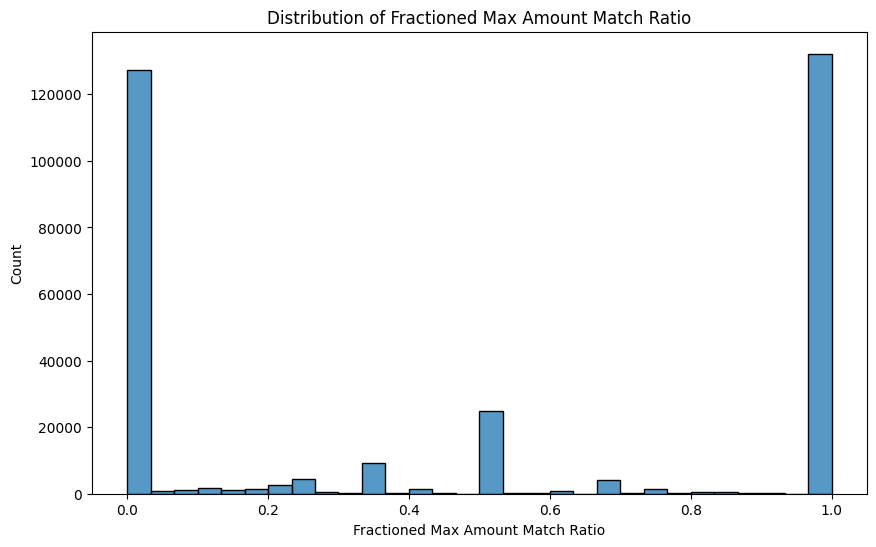

In [15]:
account_series = account_grouped_df.loc[~account_grouped_df['fractioned_max_amt_match_ratio'].isna(), 'fractioned_max_amt_match_ratio']

fig, ax = plt.subplots(figsize=(10,6))
sns.histplot(account_series, bins=30, ax=ax)
ax.set_title('Distribution of Fractioned Max Amount Match Ratio')
ax.set_xlabel('Fractioned Max Amount Match Ratio')
ax.set_ylabel('Count')
plt.show()

Well this result shows something really interesting. In many accounts (approx the half of all) have fractioned transactions with an amount equal to the maximum it can reach.
- This is expected, as in many cases the reason why one split the whole transaction in fractions is due to it could reach the account limit, or threshold.
- However the other half of fractioned transactions (the peak in 0.0) shows that is not related with the maximum transaction that these accounts can reach.

# lets perform the same graphics as in the case of the merchants to see if there is something interesting to observe.

- plot the distrib for transa
- Max Transaction Amount Distrib per accounts
- Average Amount Distrib per accounts

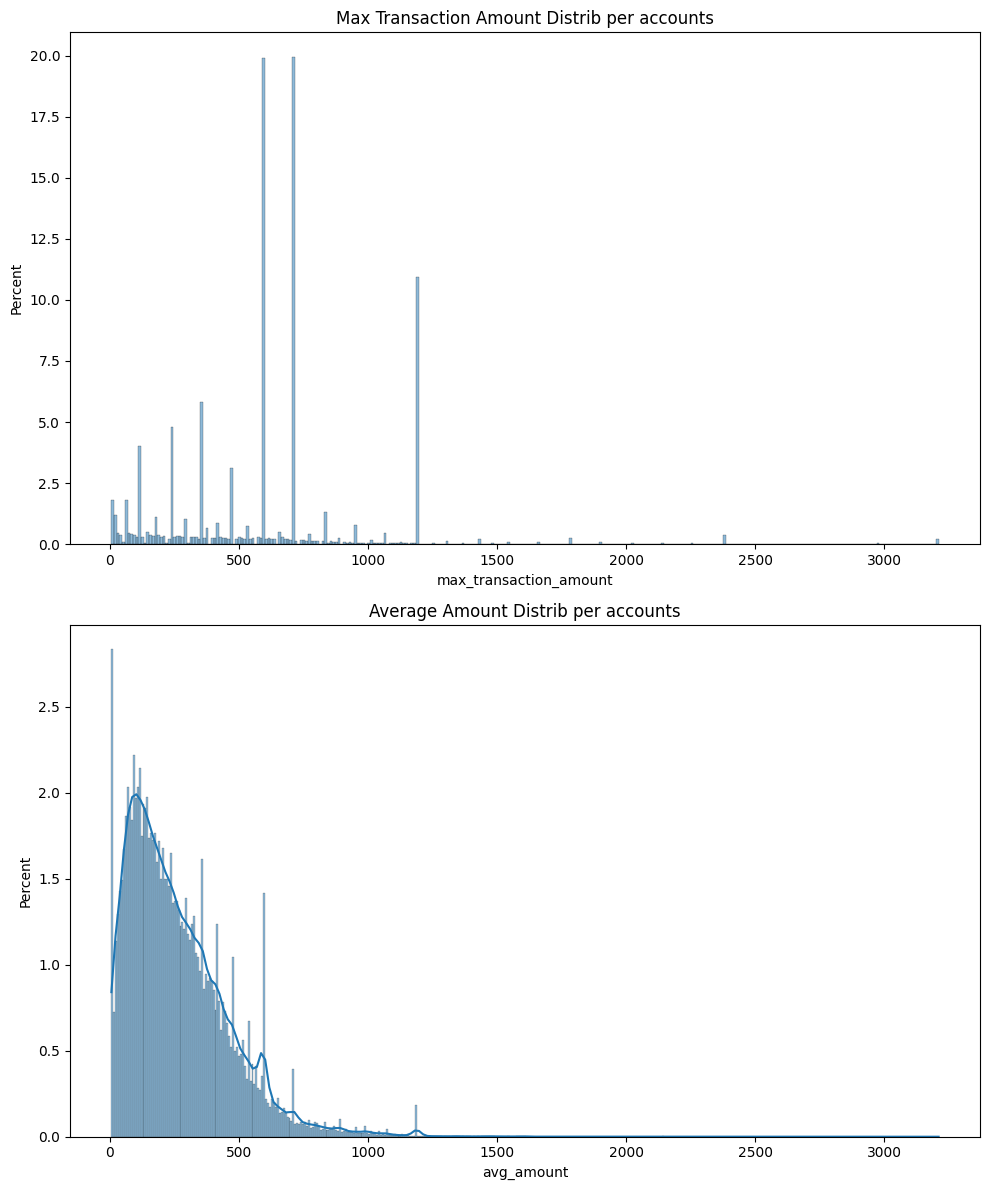

In [16]:
fig, ax = plt.subplots(2, 1, figsize=(10, 6*2))

subsidiary_counts = {}
account_group = account_grouped_df.dropna()

sns.histplot(account_group['max_transaction_amount'], ax=ax[0], kde=False, stat='percent', alpha=0.5)
ax[0].set_title(f'Max Transaction Amount Distrib per accounts')
sns.histplot(account_group['avg_amount'], ax=ax[1], kde=True, stat='percent')
ax[1].set_title(f'Average Amount Distrib per accounts')


plt.tight_layout()
plt.show()


# Important facts

- In the distribution of the maximum values or amounts reached by some accounts, it is noticed that there are many well defined peaks.
- This is, there are some defined maximum amounts, which should be the max transaction limits that many accounts have in common, that is the reason why in some specif values, the frequency is so high (many accounts share the same limit)
- The avg transaction amount per account follows a normal distribution, again this is expected considering the Central Limit Theorem.

**End of exploration notebook**